# 第5章 ロジスティック回帰とROC曲線：学習モデルの評価方法(自習書き込み用）

## 「05-roc_curve」の解説

ITエンジニアための機械学習理論入門「第5章 ロジスティック回帰とROC曲線:学習モデルの評価方法」で使用しているサンプルコード「05-roc_curve.py」の解説です。

※ 解説用にコードの内容は少し変更しています。

はじめに必要なモジュールをインポートしておきます。

関数 multivariate_normal は、多次元の正規分布に従う乱数を生成するために利用します。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import multivariate_normal

import matplotlib
matplotlib.rcParams['font.size'] = 12

トレーニング用データを生成する関数を用意します。

平面上の○☓の2種類のデータについて、それぞれの「個数、中心座標、分散」を引数で指定します。

In [2]:
def prepare_dataset(n1, mu1, variance1, n2, mu2, variance2):
    df1 = DataFrame(multivariate_normal(mu1, np.eye(2)*variance1 ,n1),
                    columns=['x','y'])
    df1['type'] = 1
    df2 = DataFrame(multivariate_normal(mu2, np.eye(2)*variance2, n2),
                    columns=['x','y'])
    df2['type'] = -1
    df = pd.concat([df1,df2], ignore_index=True)
    df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
    return df

ロジスティック回帰で分割線を決定する関数を用意します。

ここでは、得られた結果を用いて、トレーニングセットの各データに対して確率の値を付与したデータフレームも返却するようにしています。

In [3]:
# ロジスティック回帰
def run_logistic(train_set):
    pd.options.mode.chained_assignment = None
    #ベクトルwを生成する。とりあえずの値に初期化する
    w = np.array([[0], [0.1], [0.1]])
    #ベクトルφを作る。train_setにはtypeが存在し、邪魔なのでtrain_setからtypeを消去したものをφとする
    phi = train_set[['x', 'y']]
    #bias項が必要のため作成する。初期値は1（初期値に特に意味はない)。
    phi['bias'] = 1
    #DataFrameからnumpyの配列に変換する
    phi = phi[['bias', 'x', 'y']].values
    #どちらに分類されるか(直線の上か、下か)を示すデータ(1 or 0)を作成する
    t = (train_set[['type']] + 1)*0.5 # type = 1, -1 を type = 1, 0 に変換（別の問題のトレーニングセット生成関数を流用したためこれが必要）
    #numpyの配列に変換する
    t = t.values
    #ちなみに、tは縦ベクトルになっている（注意）
    print("=== PRINT T =====")
    print(t)

    # 最大100回のIterationを実施
    for i in range(100):
        # IRLS法によるパラメータの修正
        ### [START] 対角行列Rを作る ###
        y = np.array([])
        for line in phi:
            a = np.dot(line, w)
            y = np.append(y, [1.0/(1.0+np.exp(-a))]) #ロジスティック関数からそのテストデータline(bias,x,y)の属性が1の確率を求め、znの配列をつくる
        r = np.diag(y*(1-y)) #求めたznの配列から対角行列を一気に作る（numpyすごい)
        ### [END] 対角行列Rを作る ###
        print("=====DEBUG=====")
        print(y)
        print("-----")
        #後でtと減算をするために、横ベクトルを転置して縦ベクトルにする
        y = y[np.newaxis,:].T
        print(y)
        print("=====DEBUG=====")
        #IRLS法の計算をする（ニユートンラフソン更新）
        tmp1 = np.linalg.inv(np.dot(np.dot(phi.T, r),phi))
        tmp2 = np.dot(phi.T, (y-t))
        w_new = w - np.dot(tmp1, tmp2)
        # パラメータの変化が 0.1% 未満になったら終了
        #ノルムの二乗なので、それぞれのベクトルの内積を計算している。
        print("==== DEBUG2 ====")
        print("numpyではベクトルの内積を求める際には、横ベクトル×縦ベクトルである必要がある")
        print("-> w_new-w")
        print(w_new-w)
        print("-> (w_new-w).T")
        print((w_new-w).T)
        print("-> w")
        print(w)
        print("#計算結果は1行1列の行列になる")
        print(np.dot((w_new-w).T, (w_new-w)))
        print("#こちらはエラーになる")
        try:
            print(np.dot((w_new-w).T, (w_new-w).T))
        except Exception as e:
            print(e)
            
        print("#内積の計算結果(1行1列)はスカラーとして扱うことができるらしい")
        print(np.dot((w_new-w).T, (w_new-w)))
        print(np.dot((w_new-w).T, (w_new-w)) < 10)
        
        if np.dot((w_new-w).T, (w_new-w)) < 0.001 * np.dot(w.T, w):
            w = w_new
            break
        w = w_new
        
    # 分類誤差の計算
    w0, w1, w2 = w[0], w[1], w[2]
    err = 0
    for index, line in train_set.iterrows():
        a = np.dot(np.array([1, line.x, line.y]), w)
        p = 1.0/(1.0+np.exp(-a))
        train_set.loc[index, 'probability'] = p
        if (p-0.5)*line.type < 0: #誤って分類されている場合はこの計算結果は負になる。ロジスティック関数の0.5より上は正。下は負になるため。
            err += 1
    err_rate = err * 100 / len(train_set)
    result = train_set.sort_values(by=['probability'], ascending=[False]).reset_index()
    
    print(" ==== PRINT RESULT ===")
    print(result)
    
    return w0, w1, w2, err_rate, result

結果をグラフ、および、ROC曲線として表示する関数を用意します。

In [4]:
# 結果の表示
def show_result(subplot, train_set, w0, w1, w2, err_rate):
    train_set1 = train_set[train_set['type']==1]
    train_set2 = train_set[train_set['type']==-1]
    ymin, ymax = train_set.y.min()-5, train_set.y.max()+10
    xmin, xmax = train_set.x.min()-5, train_set.x.max()+10

    subplot.set_ylim([ymin-1, ymax+1])
    subplot.set_xlim([xmin-1, xmax+1])
    subplot.scatter(train_set1.x, train_set1.y, marker='o', label=None)
    subplot.scatter(train_set2.x, train_set2.y, marker='x', label=None)

    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - w0 / w2
    label = "ERR %.2f%%" % err_rate
    subplot.plot(linex, liney, label=label, color='red')
    subplot.legend(loc=1)

In [5]:
# ROC曲線の表示
def draw_roc(subplot, result):
    positives = len(result[result['type']==1])
    negatives = len(result[result['type']==-1])
    tp = [0.0] * len(result)
    fp = [0.0] * len(result)
    for index, line in result.iterrows():
        for c in np.arange(0, len(result)):
            if index < c:
                if line.type == 1:
                    tp[c] += 1
                else:
                    fp[c] += 1
    tp_rate = np.array(tp) / positives
    fp_rate = np.array(fp) / negatives
    
    print("=== DEBUG tp_rate and fp_rate")
    print("TP RATE")
    print(tp_rate)
    print("FP RATE")
    print(fp_rate)

    subplot.set_ylim([0, 1])
    subplot.set_xlim([0, 1])
    subplot.set_xlabel("False positive rate")
    subplot.set_ylabel("True positive rate")
    subplot.plot(fp_rate, tp_rate)

比較的分散が小さくて、分類が容易なトレーニングセットを用意します。

In [6]:
train_set = prepare_dataset(80, [9, 9], 50, 200, [-3, -3], 50)

ロジスティック回帰を適用した結果を表示します。

=== PRINT T =====
[[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.

=== DEBUG tp_rate and fp_rate
TP RATE
[0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125  0.1375 0.15   0.1625 0.175  0.1875 0.2    0.2125 0.225  0.2375
 0.25   0.2625 0.275  0.2875 0.3    0.3125 0.325  0.3375 0.35   0.3625
 0.375  0.3875 0.4    0.4125 0.425  0.4375 0.4375 0.45   0.4625 0.475
 0.475  0.4875 0.5    0.5    0.5125 0.525  0.5375 0.5375 0.55   0.5625
 0.575  0.5875 0.6    0.6    0.6125 0.625  0.6375 0.6375 0.65   0.6625
 0.675  0.675  0.6875 0.7    0.7125 0.7125 0.7125 0.725  0.725  0.7375
 0.7375 0.7375 0.75   0.7625 0.775  0.775  0.7875 0.7875 0.8    0.8125
 0.8125 0.825  0.825  0.825  0.8375 0.8375 0.8375 0.8375 0.8375 0.8375
 0.8375 0.8375 0.8375 0.8375 0.85   0.8625 0.875  0.875  0.875  0.8875
 0.9    0.9    0.9    0.9    0.9    0.9    0.9    0.9    0.9    0.9
 0.9    0.9125 0.9125 0.9125 0.9125 0.9125 0.9125 0.9125 0.9125 0.9125
 0.9125 0.9125 0.9125 0.9125 0.9125 0.9125 0.9125 0.925  0.925  0.925
 0.925  0.925  0.9375 0.9375 0.9375 0.95   0

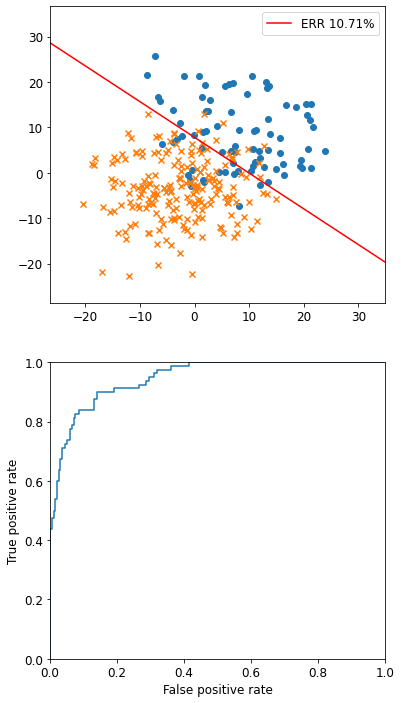

In [7]:
w0, w1, w2, err_rate, result = run_logistic(train_set)
fig = plt.figure(figsize=(6, 12))
subplot = fig.add_subplot(2, 1, 1)
show_result(subplot, train_set, w0, w1, w2, err_rate)
subplot = fig.add_subplot(2, 1, 2)
draw_roc(subplot, result)

分散が大きくて、分類が困難なトレーニングセットを用意します。

In [8]:
train_set = prepare_dataset(80, [9, 9], 150, 200, [-3, -3], 150)

ロジスティック回帰を適用した結果を表示します。

=== PRINT T =====
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.

=====DEBUG=====
[0.46560319 0.39548789 0.19581488 0.6067946  0.54038569 0.53177718
 0.73327128 0.11341047 0.06171289 0.42688907 0.13810665 0.42647982
 0.22842479 0.02963601 0.58472149 0.59252195 0.03012291 0.76906884
 0.83177041 0.65435683 0.48324958 0.46948646 0.32992546 0.35397304
 0.0814981  0.14968145 0.14893043 0.52710081 0.43004634 0.04381876
 0.01183193 0.38741197 0.4089598  0.30808749 0.64935317 0.20619713
 0.60348696 0.08959598 0.33027032 0.57352586 0.52465613 0.02303736
 0.08031644 0.02553482 0.15745121 0.14428193 0.72949601 0.97046666
 0.1813229  0.55946876 0.73406852 0.4799264  0.12297758 0.0024575
 0.10831435 0.01864275 0.06402465 0.29835397 0.94073307 0.01621931
 0.87684788 0.31852709 0.13583438 0.06461182 0.21999941 0.01011831
 0.09251812 0.52924792 0.48731146 0.10404783 0.04029378 0.08562196
 0.20973461 0.23993269 0.22248786 0.2422991  0.31544274 0.15268177
 0.27273881 0.29752618 0.30376465 0.01985709 0.03736108 0.05915426
 0.53773589 0.07057153 0.56635948 0.3345861  0.

=== DEBUG tp_rate and fp_rate
TP RATE
[0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125  0.1375 0.15   0.15   0.1625 0.175  0.1875 0.1875 0.1875 0.2
 0.2125 0.225  0.225  0.225  0.225  0.2375 0.25   0.2625 0.275  0.2875
 0.3    0.3    0.3125 0.3125 0.325  0.325  0.325  0.3375 0.35   0.35
 0.35   0.3625 0.3625 0.3625 0.3625 0.3625 0.375  0.375  0.375  0.375
 0.3875 0.4    0.4125 0.425  0.4375 0.4375 0.45   0.45   0.4625 0.475
 0.4875 0.5    0.5    0.5125 0.525  0.5375 0.55   0.5625 0.5625 0.5625
 0.575  0.5875 0.6    0.6    0.6125 0.625  0.625  0.625  0.6375 0.65
 0.6625 0.6625 0.6625 0.675  0.675  0.6875 0.7    0.7    0.7    0.7125
 0.725  0.7375 0.7375 0.7375 0.75   0.75   0.75   0.7625 0.775  0.775
 0.775  0.775  0.7875 0.7875 0.7875 0.7875 0.7875 0.7875 0.7875 0.7875
 0.8    0.8    0.8    0.8    0.8125 0.8125 0.8125 0.825  0.825  0.825
 0.825  0.825  0.8375 0.8375 0.8375 0.8375 0.8375 0.8375 0.8375 0.8375
 0.8375 0.8375 0.85   0.8625 0.8625 0.8625 0.8625 

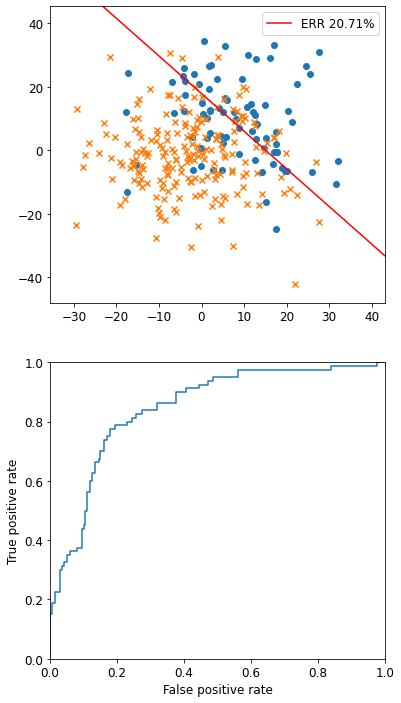

In [9]:
w0, w1, w2, err_rate, result = run_logistic(train_set)
fig = plt.figure(figsize=(6, 12))
subplot = fig.add_subplot(2, 1, 1)
show_result(subplot, train_set, w0, w1, w2, err_rate)
subplot = fig.add_subplot(2, 1, 2)
draw_roc(subplot, result)